In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
sns.set_palette("Set2")

In [2]:
from dotenv import load_dotenv
from ephys_queries import db_setup_core, select_spike_times, select_discrete_data
from spiketimes.df.alignment import align_around_by
from spiketimes.df.binning import binned_spiketrain_bins_provided
from spiketimes.df.baseline import zscore_standardise_by
from spiketimes.df.statistics import diffmeans_test_by
from spiketimes.utils import p_adjust
from spiketimes.plots import add_event_vlines

In [3]:
from scipy.ndimage import gaussian_filter1d
from scipy.stats import zscore
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

In [4]:
data_dir = Path(".").absolute().parent / "data"
fig_dir = Path(".").absolute().parent / "figs"

### Import Data

In [5]:
group_names = ["acute_citalopram", 
            "acute_saline", 
            "shock", 
            "sham", 
            "acute_cit", 
            "acute_sal"]
dfb = (
    pd.read_csv(data_dir / "baseline.csv")
    .loc[lambda x: x["group_name"].isin(group_names)]
)

In [6]:
block_name = "base_shock"
fs = 30000
load_dotenv()
engine, metadata = db_setup_core()

df_spikes = (
    select_spike_times(
            engine, 
            metadata,
            group_names=group_names,
            block_name=block_name,
            )
    .assign(spiketimes=lambda x: x["spike_time_samples"].divide(fs))
)
df_events = (
    select_discrete_data(
            engine,
            metadata,
            group_names=group_names,
            block_name=block_name
    )
    .assign(event_s= lambda x: x["timepoint_sample"].divide(fs))
)

### Apply Exclusion Criteria

In [7]:
df_spikes2 = df_spikes.groupby("neuron_id").filter(lambda x: len(x) >= 300)

In [8]:
df_spikes2.groupby("neuron_id").apply(len).reset_index().merge(dfb).dropna().session_name.unique()

array(['hamilton_04', 'hamilton_09', 'hamilton_31', 'hamilton_38',
       'hamilton_37', 'hamilton_35', 'hamilton_36', 'hamilton_32'],
      dtype=object)

In [9]:
df_spikes2.neuron_id.nunique()

218

### Construct PSTH

In [10]:
bins = np.round(np.arange(-0.5, 1.51, 0.01), 3)

psth = (
    align_around_by(
        df_data=df_spikes2.merge(dfb[["neuron_id", "session_name"]]).dropna(),
        df_data_data_colname="spiketimes",
        df_data_group_colname="session_name",
        df_events=df_events,
        df_events_event_colname="event_s",
        df_events_group_colname="session_name",
        max_latency=1.5,
        t_before=0.5)
    .dropna()
    .pipe(lambda x: binned_spiketrain_bins_provided(x, 
                                bins=bins, 
                                spiketimes_col="aligned", 
                                spiketrain_col="neuron_id")
         )
)

c:\users\rory\repos\spiketimes\spiketimes\alignment.py:140: RuntimeWarning: invalid value encountered in greater_equal
  (negative_latencies >= (t_before * -1)),
c:\users\rory\repos\spiketimes\spiketimes\alignment.py:148: RuntimeWarning: invalid value encountered in greater
  latencies[latencies > max_latency] = np.nan


### Permutation Tests

##### Define Conditions

In [11]:
psth = (
    psth
    .assign(cond=(
        lambda x: x["bin"].apply(lambda y: 0 if (y < 0.02) or (y > 0.3) else 1)
            ))
)

##### Define Responders

In [12]:
def response_dm(row, p_colname="p", diff_of_means_colname="diff_of_means"):
    if row[p_colname] >= 0.05:
        return "Non Responder"
    elif row[diff_of_means_colname] < 0:
        return "Inhibited"
    else:
        return "Stimulated"

df_effects = (
    diffmeans_test_by(df=psth, 
                        spiketrain_col="neuron_id", 
                        spikecount_col="counts", 
                        condition_col="cond")
    .rename(columns={"diff_of_means": "diff_of_means_baseshock",
                    "p": "p_baseshock"})
    .assign(p_baseshock = lambda x: p_adjust(x["p_baseshock"]),
            response_baseshock= lambda x: x.apply(response_dm, 
                                                  axis=1, 
                                                  p_colname="p_baseshock",
                                                  diff_of_means_colname="diff_of_means_baseshock"))
    .merge(dfb[["neuron_id", "cluster"]].drop_duplicates())
)

In [13]:
df_effects.head(3)

,neuron_id,diff_of_means_baseshock,p_baseshock,response_baseshock,cluster
0,1031,13.920548,0.0,Stimulated,slow_regular
1,1032,25.341198,0.0,Stimulated,slow_regular
2,1034,11.050817,0.0,Stimulated,slow_regular


In [14]:
df_effects.response_baseshock.value_counts()

Stimulated       104
Non Responder     79
Inhibited         35
Name: response_baseshock, dtype: int64

### Plot Heatmaps

### ALL

##### Create Smoothed Data

In [15]:
psth_plot = (
    psth
    .pipe(lambda x: zscore_standardise_by(df=x, 
                      baseline_start_stop=np.array([-0.5, 0]),
                      time_col="bin",
                      data_col="counts", 
                      spiketrain_col="neuron_id"))
    .assign(z_smooth= lambda x: x.groupby("neuron_id")["zscore"]
                    .transform(lambda x: gaussian_filter1d(zscore(x), sigma=0.8)))
    .pivot(columns="bin", index="neuron_id", values="z_smooth")
    .reset_index()
    .merge(df_effects[["neuron_id", "response_baseshock"]])
)

c1 = psth_plot[psth_plot["response_baseshock"] == "Stimulated"].drop(["neuron_id", "response_baseshock"], axis=1).sort_values(by=0.1, ascending=False)
c2 = psth_plot[psth_plot["response_baseshock"] == "Inhibited"].drop(["neuron_id", "response_baseshock"], axis=1).sort_values(by=0.1, ascending=False)
c3 = psth_plot[psth_plot["response_baseshock"] == "Non Responder"].drop(["neuron_id", "response_baseshock"], axis=1).sort_values(by=0.1, ascending=False)

##### Stimulated Units

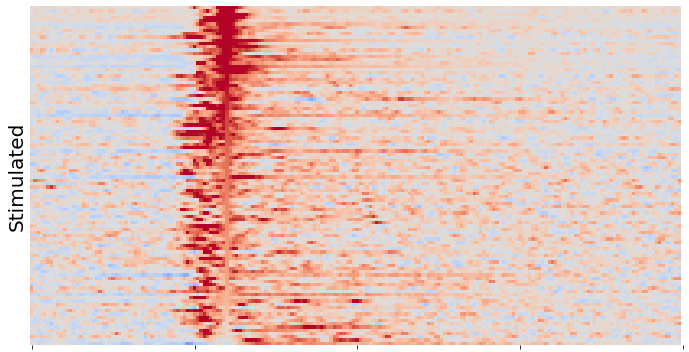

In [16]:
f, ax = plt.subplots(figsize=(10, 5))
ax.imshow(c1, cmap="coolwarm", vmin=-3.5, vmax=2.5)


ax.set_ylabel("Stimulated", fontsize=20)
ax.set_yticklabels([])
ax.set_yticks([])

ax.set(frame_on=False)
ticks = np.array([0, 50, 100, 150, 200])
ax.set_xticks(ticks)
ax.set_xticklabels([])


plt.tight_layout()
# plt.savefig(fig_dir / "psth_stimulated_heat.svg", dpi=300, transparent=True)

##### Inhibited Units

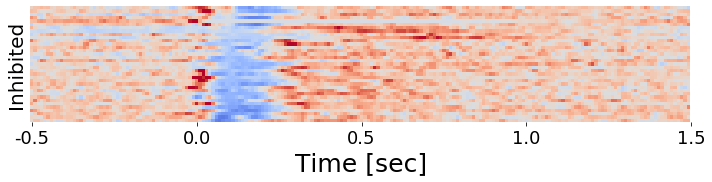

In [17]:
f, ax = plt.subplots(figsize=(10, 5))
ax.imshow(c2, cmap="coolwarm", vmin=-3.5, vmax=2.5)
ax.set_ylabel("Inhibited", fontsize=20)


ax.set_yticklabels([])
ax.set_yticks([])
ax.set(frame_on=False)
ax.set_xticks(ticks)
ax.set_xticklabels(np.round((ticks-50) * 0.01, 2), fontsize=18)
ax.set_xlabel("Time [sec]", fontsize=25)
plt.tight_layout()
# plt.savefig(fig_dir / "psth_inhibited_heat.svg", dpi=300, transparent=True)

##### Non Responders

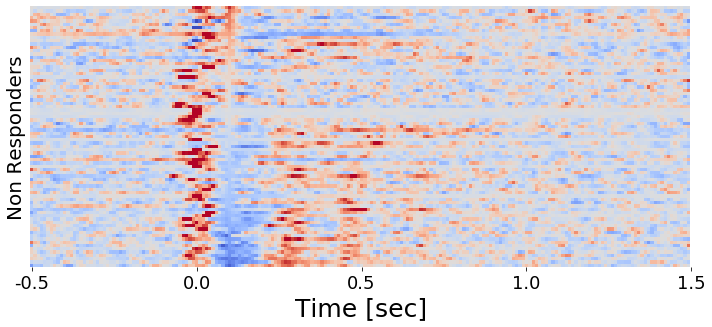

In [18]:
f, ax = plt.subplots(figsize=(10, 5))
ax.imshow(c3, cmap="coolwarm", vmin=-2.5, vmax=2.5)
ax.set_ylabel("Non Responders", fontsize=20)

ax.set_yticklabels([])
ax.set_yticks([])
ax.set(frame_on=False)
ax.set_xticks(ticks)
ax.set_xticklabels(np.round((ticks-50) * 0.01, 2), fontsize=18)
ax.set_xlabel("Time [sec]", fontsize=25)
plt.tight_layout()
# plt.savefig(fig_dir / "psth_nonresponders_heat.svg", dpi=300, transparent=True)

## SR

In [19]:
psth_plot = (
    psth
    .pipe(lambda x: zscore_standardise_by(df=x, 
                      baseline_start_stop=np.array([-0.5, 0]),
                      time_col="bin",
                      data_col="counts", 
                      spiketrain_col="neuron_id"))
    .assign(z_smooth= lambda x: x.groupby("neuron_id")["zscore"]
                    .transform(lambda x: gaussian_filter1d(x, sigma=1.3)))
    .pivot(columns="bin", index="neuron_id", values="z_smooth")
    .reset_index()
    .merge(df_effects[["neuron_id", "response_baseshock", "cluster"]])
    .loc[lambda x: x.cluster == "slow_regular"]
    .drop("cluster", axis=1)
)

c1 = psth_plot[psth_plot["response_baseshock"] == "Stimulated"].drop(["neuron_id", "response_baseshock"], axis=1).sort_values(by=0.2, ascending=False)
c2 = psth_plot[psth_plot["response_baseshock"] == "Inhibited"].drop(["neuron_id", "response_baseshock"], axis=1).sort_values(by=0.2, ascending=False)
c3 = psth_plot[psth_plot["response_baseshock"] == "Non Responder"].drop(["neuron_id", "response_baseshock"], axis=1).sort_values(by=0.2, ascending=False)

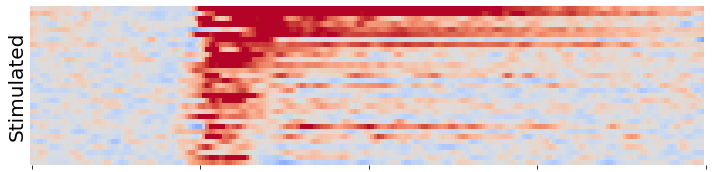

In [20]:
f, ax = plt.subplots(figsize=(10, 2.5))
ax.imshow(c1, cmap="coolwarm", vmin=-3.5, vmax=3.5, aspect="auto")


ax.set_ylabel("Stimulated", fontsize=20)
ax.set_yticklabels([])
ax.set_yticks([])

ax.set(frame_on=False)
ticks = np.array([0, 50, 100, 150, 200])
ax.set_xticks(ticks)
ax.set_xticklabels([])


plt.tight_layout()
# plt.savefig(fig_dir / "SR_psth_activated_heat.svg", dpi=300, transparent=True)

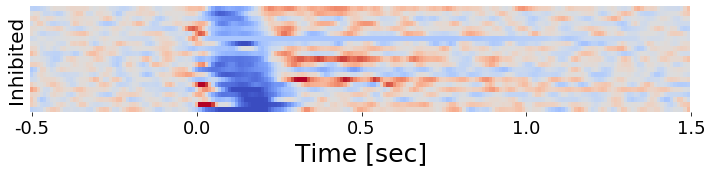

In [21]:
f, ax = plt.subplots(figsize=(10, 2.5))
ax.imshow(c2, cmap="coolwarm", vmin=-3.5, vmax=3.5, aspect="auto")
ax.set_ylabel("Inhibited", fontsize=20)
ax.set_yticklabels([])
ax.set_yticks([])
ax.set(frame_on=False)
ax.set_xticks(ticks)
ax.set_xticklabels(np.round((ticks-50) * 0.01, 2), fontsize=18)
ax.set_xlabel("Time [sec]", fontsize=25)
plt.tight_layout()
# plt.savefig(fig_dir / "SR_psth_inhibited_heat.svg", dpi=300, transparent=True)

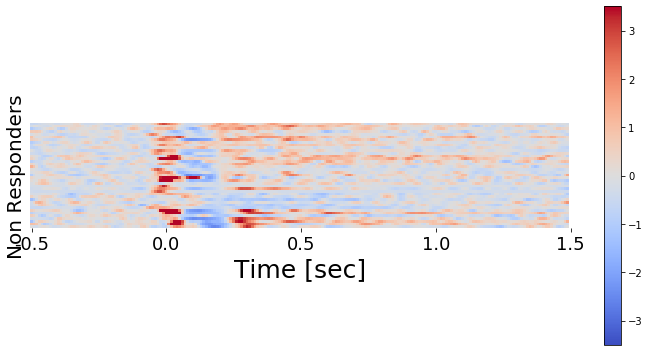

In [22]:
f, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(c3, cmap="coolwarm", vmin=-3.5, vmax=3.5)
ax.set_ylabel("Non Responders", fontsize=20)

ax.set_yticklabels([])
ax.set_yticks([])
ax.set(frame_on=False)
ax.set_xticks(ticks)
ax.set_xticklabels(np.round((ticks-50) * 0.01, 2), fontsize=18)
ax.set_xlabel("Time [sec]", fontsize=25)
f.colorbar(im)
plt.tight_layout()
# plt.savefig(fig_dir / "psth_colorbar.svg", dpi=300, transparent=True)

### FF

In [23]:
psth_plot = (
    psth
    .pipe(lambda x: zscore_standardise_by(df=x, 
                      baseline_start_stop=np.array([-0.5, 0]),
                      time_col="bin",
                      data_col="counts", 
                      spiketrain_col="neuron_id"))
    .assign(z_smooth= lambda x: x.groupby("neuron_id")["zscore"]
                    .transform(lambda x: gaussian_filter1d(x, sigma=1.3)))
    .pivot(columns="bin", index="neuron_id", values="z_smooth")
    .reset_index()
    .merge(df_effects[["neuron_id", "response_baseshock", "cluster"]])
    .loc[lambda x: x.cluster == "fast_firing"]
    .drop("cluster", axis=1)
)

c1 = psth_plot[psth_plot["response_baseshock"] == "Stimulated"].drop(["neuron_id", "response_baseshock"], axis=1).sort_values(by=0.2, ascending=False)
c2 = psth_plot[psth_plot["response_baseshock"] == "Inhibited"].drop(["neuron_id", "response_baseshock"], axis=1).sort_values(by=0.2, ascending=False)
c3 = psth_plot[psth_plot["response_baseshock"] == "Non Responder"].drop(["neuron_id", "response_baseshock"], axis=1).sort_values(by=0.2, ascending=False)

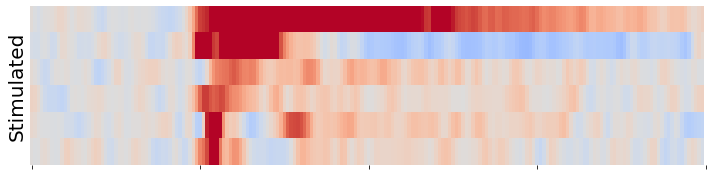

In [24]:
f, ax = plt.subplots(figsize=(10, 2.5))
ax.imshow(c1, cmap="coolwarm", vmin=-4.5, vmax=4.5, aspect="auto")


ax.set_ylabel("Stimulated", fontsize=20)
ax.set_yticklabels([])
ax.set_yticks([])

ax.set(frame_on=False)
ticks = np.array([0, 50, 100, 150, 200])
ax.set_xticks(ticks)
ax.set_xticklabels([])

plt.tight_layout()
# plt.savefig(fig_dir / "FF_psth_activated_heat.svg", dpi=300, transparent=True)

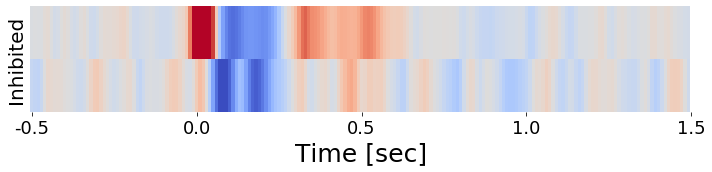

In [25]:
f, ax = plt.subplots(figsize=(10, 2.5))
ax.imshow(c2, cmap="coolwarm", vmin=-4.5, vmax=4.5, aspect="auto")
ax.set_ylabel("Inhibited", fontsize=20)
ax.set_yticklabels([])
ax.set_yticks([])
ax.set(frame_on=False)
ax.set_xticks(ticks)
ax.set_xticklabels(np.round((ticks-50) * 0.01, 2), fontsize=18)
ax.set_xlabel("Time [sec]", fontsize=25)
plt.tight_layout()
# plt.savefig(fig_dir / "FF_psth_inhibited_heat.svg", dpi=300, transparent=True)

## SIR

In [26]:
psth_plot = (
    psth
    .pipe(lambda x: zscore_standardise_by(df=x, 
                      baseline_start_stop=np.array([-0.5, 0]),
                      time_col="bin",
                      data_col="counts", 
                      spiketrain_col="neuron_id"))
    .assign(z_smooth= lambda x: x.groupby("neuron_id")["zscore"]
                    .transform(lambda x: gaussian_filter1d(x, sigma=1.3)))
    .pivot(columns="bin", index="neuron_id", values="z_smooth")
    .reset_index()
    .merge(df_effects[["neuron_id", "response_baseshock", "cluster"]])
    .loc[lambda x: x.cluster == "slow_irregular"]
    .drop("cluster", axis=1)
)

c1 = psth_plot[psth_plot["response_baseshock"] == "Stimulated"].drop(["neuron_id", "response_baseshock"], axis=1).sort_values(by=0.2, ascending=False)
c2 = psth_plot[psth_plot["response_baseshock"] == "Inhibited"].drop(["neuron_id", "response_baseshock"], axis=1).sort_values(by=0.2, ascending=False)
c3 = psth_plot[psth_plot["response_baseshock"] == "Non Responder"].drop(["neuron_id", "response_baseshock"], axis=1).sort_values(by=0.2, ascending=False)

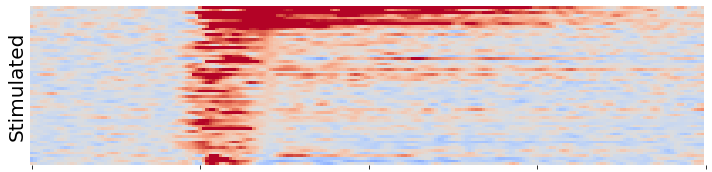

In [27]:
f, ax = plt.subplots(figsize=(10, 2.5))
ax.imshow(c1, cmap="coolwarm", vmin=-3.5, vmax=3.5, aspect="auto")


ax.set_ylabel("Stimulated", fontsize=20)
ax.set_yticklabels([])
ax.set_yticks([])

ax.set(frame_on=False)
ticks = np.array([0, 50, 100, 150, 200])
ax.set_xticks(ticks)
ax.set_xticklabels([])


plt.tight_layout()
# plt.savefig(fig_dir / "SIR_psth_activated_heat.svg", dpi=300, transparent=True)

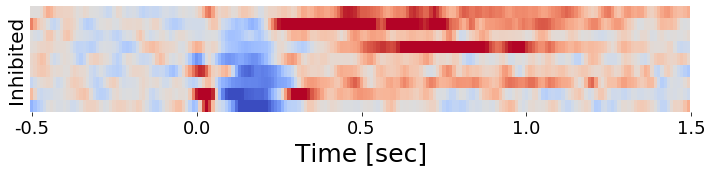

In [28]:
f, ax = plt.subplots(figsize=(10, 2.5))
ax.imshow(c2, cmap="coolwarm", vmin=-3.5, vmax=3.5, aspect="auto")
ax.set_ylabel("Inhibited", fontsize=20)
ax.set_yticklabels([])
ax.set_yticks([])
ax.set(frame_on=False)
ax.set_xticks(ticks)
ax.set_xticklabels(np.round((ticks-50) * 0.01, 2), fontsize=18)
ax.set_xlabel("Time [sec]", fontsize=25)
plt.tight_layout()
# plt.savefig(fig_dir / "SIR_psth_inhibited_heat.svg", dpi=300, transparent=True)

## NSA

In [29]:
psth_plot = (
    psth
    .pipe(lambda x: zscore_standardise_by(df=x, 
                      baseline_start_stop=np.array([-0.5, 0]),
                      time_col="bin",
                      data_col="counts", 
                      spiketrain_col="neuron_id"))
    .assign(z_smooth= lambda x: x.groupby("neuron_id")["zscore"]
                    .transform(lambda x: gaussian_filter1d(x, sigma=1.3)))
    .pivot(columns="bin", index="neuron_id", values="z_smooth")
    .reset_index()
    .merge(df_effects[["neuron_id", "response_baseshock", "cluster"]])
    .loc[lambda x: x.cluster == "no_baseline"]
    .drop("cluster", axis=1)
)

c1 = psth_plot[psth_plot["response_baseshock"] == "Stimulated"].drop(["neuron_id", "response_baseshock"], axis=1).sort_values(by=0.2, ascending=False)
c2 = psth_plot[psth_plot["response_baseshock"] == "Inhibited"].drop(["neuron_id", "response_baseshock"], axis=1).sort_values(by=0.2, ascending=False)
c3 = psth_plot[psth_plot["response_baseshock"] == "Non Responder"].drop(["neuron_id", "response_baseshock"], axis=1).sort_values(by=0.2, ascending=False)

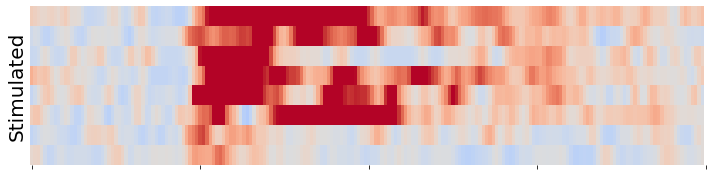

In [30]:
f, ax = plt.subplots(figsize=(10, 2.5))
ax.imshow(c1, cmap="coolwarm", vmin=-3.5, vmax=3.5, aspect="auto")


ax.set_ylabel("Stimulated", fontsize=20)
ax.set_yticklabels([])
ax.set_yticks([])

ax.set(frame_on=False)
ticks = np.array([0, 50, 100, 150, 200])
ax.set_xticks(ticks)
ax.set_xticklabels([])


plt.tight_layout()
# plt.savefig(fig_dir / "NSA_psth_activated_heat.svg", dpi=300, transparent=True)

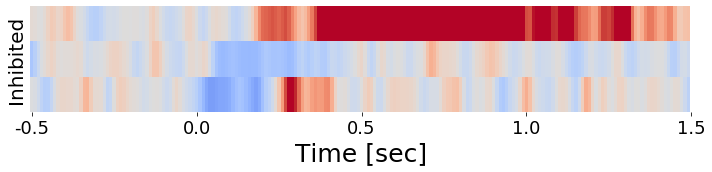

In [31]:
f, ax = plt.subplots(figsize=(10, 2.5))
ax.imshow(c2, cmap="coolwarm", vmin=-3.5, vmax=3.5, aspect="auto")
ax.set_ylabel("Inhibited", fontsize=20)
ax.set_yticklabels([])
ax.set_yticks([])
ax.set(frame_on=False)
ax.set_xticks(ticks)
ax.set_xticklabels(np.round((ticks-50) * 0.01, 2), fontsize=18)
ax.set_xlabel("Time [sec]", fontsize=25)
plt.tight_layout()
# plt.savefig(fig_dir / "NSA_psth_inhibited_heat.svg", dpi=300, transparent=True)

### Plot Example PSTH

### SR

In [32]:
df_aligned = align_around_by(
            df_data=df_spikes.merge(dfb[["neuron_id", "session_name"]]).dropna(),
            df_data_data_colname="spiketimes",
            df_data_group_colname="session_name",
            df_events=df_events,
            df_events_event_colname="event_s",
            df_events_group_colname="session_name",
            max_latency=1.5,
            t_before=0.5).dropna()

In [33]:
inhibited_neurons = df_effects[df_effects["response_baseshock"] == "Stimulated"]["neuron_id"].values
inhibited_neuron = np.random.choice(inhibited_neurons, 1)[0]

In [34]:
dfb[dfb["neuron_id"]==1813].cluster

262    slow_regular
Name: cluster, dtype: object

In [35]:
# inhibited_neuron = 1044

In [36]:
# inhibited_neuron = 1044
inhibited_neuron = 1813

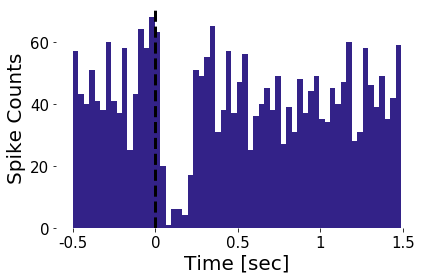

In [37]:
from spiketimes.df.binning import which_bin

f, ax = plt.subplots()

ax = which_bin(df_aligned[df_aligned["neuron_id"] == inhibited_neuron], bins[:-1], 
          spiketimes_col="aligned")["bin_values"].hist(bins=60, ax=ax, 
#                                                        color="#31A6D9",
                                                      color="#332288")

ax.grid(False)
ax.set(frame_on=False)

ax.set_yticks([0, 20, 40, 60])
ax.set_yticklabels([0, 20, 40, 60], fontsize=15)
ax.set_ylabel("Spike Counts", fontsize=20)

ax.set_xticks([-0.5, 0, 0.5, 1, 1.5])
ax.set_xticklabels([-0.5, 0, 0.5, 1, 1.5, 2], fontsize=15)

ax.set_xlabel("Time [sec]", fontsize=20)
ax = add_event_vlines(ax=ax, events=0, vline_kwargs={"linewidth": 3})

plt.tight_layout()
# plt.savefig(fig_dir /"SR_psth_inhibited_actual.svg", dpi=300, transparent=True)

In [38]:
excited_neuron = df_effects[df_effects["response_baseshock"] == "Stimulated"]["neuron_id"].values
excited_neuron = np.random.choice(excited_neuron, 1)[0]

In [39]:
excited_neuron = 1983

In [40]:
dfb[dfb["neuron_id"]==1983].cluster

371    slow_regular
Name: cluster, dtype: object

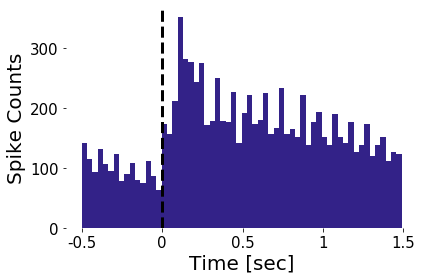

In [41]:
from spiketimes.df.binning import which_bin
f, ax = plt.subplots()

ax = which_bin(df_aligned[df_aligned["neuron_id"] == excited_neuron], bins[:-1], 
          spiketimes_col="aligned")["bin_values"].hist(bins=60, ax=ax, 
#                                                        color="#F6931D",
                                                      color="#332288")

ax.grid(False)
ax.set(frame_on=False)

ax.set_yticks([0, 100, 200, 300])
ax.set_yticklabels([0, 100, 200, 300], fontsize=15)
ax.set_ylabel("Spike Counts", fontsize=20)

ax.set_xticks([-0.5, 0, 0.5, 1, 1.5])
ax.set_xticklabels([-0.5, 0, 0.5, 1, 1.5, 2], fontsize=15)

ax.set_xlabel("Time [sec]", fontsize=20)

ax = add_event_vlines(ax=ax, events=0, vline_kwargs={"linewidth": 3})

plt.tight_layout()
# plt.savefig(fig_dir / "SR_psth_stimulated_actual.svg", dpi=300, transparent=True)

## SIR

In [42]:
stimulated_neurons = (
    df_effects
    .loc[lambda x: x["response_baseshock"] == "Stimulated"]
    .loc[lambda x: x.cluster == "slow_irregular"]
    ["neuron_id"].values
)
stimulated_neuron = np.random.choice(stimulated_neurons, 1)[0]
print(stimulated_neuron)

1671


In [43]:
stimulated_neuron = 1951

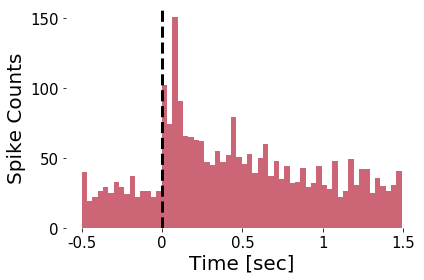

In [44]:
f, ax = plt.subplots()

ax = which_bin(df_aligned[df_aligned["neuron_id"] == stimulated_neuron], bins[:-1], 
          spiketimes_col="aligned")["bin_values"].hist(bins=60, ax=ax, 
                                                      color="#CC6677")

ax.grid(False)
ax.set(frame_on=False)

ax.set_yticks([0, 50, 100, 150])
ax.set_yticklabels(ax.get_yticks(), fontsize=15)
ax.set_ylabel("Spike Counts", fontsize=20)

ax.set_xticks([-0.5, 0, 0.5, 1, 1.5])
ax.set_xticklabels([-0.5, 0, 0.5, 1, 1.5, 2], fontsize=15)

ax.set_xlabel("Time [sec]", fontsize=20)
ax = add_event_vlines(ax=ax, events=0, vline_kwargs={"linewidth": 3})

plt.tight_layout()
# plt.savefig(fig_dir / "SIR_psth_stimulated_actual.svg", dpi=300, transparent=True)

In [45]:
inhibited_neurons = (
    df_effects
    .loc[lambda x: x["response_baseshock"] == "Inhibited"]
    .loc[lambda x: x.cluster == "slow_irregular"]
    ["neuron_id"].values
)
inhibited_neuron = np.random.choice(inhibited_neurons, 1)[0]
print(inhibited_neuron)

1960


In [46]:
inhibited_neuron = 1960

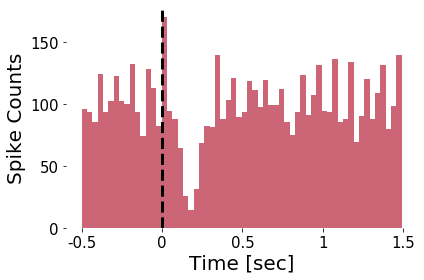

In [47]:
f, ax = plt.subplots()

ax = which_bin(df_aligned[df_aligned["neuron_id"] == inhibited_neuron], bins[:-1], 
          spiketimes_col="aligned")["bin_values"].hist(bins=60, ax=ax, 
                                                      color="#CC6677")

ax.grid(False)
ax.set(frame_on=False)

ax.set_yticks([0, 50, 100, 150])
ax.set_yticklabels([0, 50, 100, 150], fontsize=15)
ax.set_ylabel("Spike Counts", fontsize=20)

ax.set_xticks([-0.5, 0, 0.5, 1, 1.5])
ax.set_xticklabels([-0.5, 0, 0.5, 1, 1.5, 2], fontsize=15)

ax.set_xlabel("Time [sec]", fontsize=20)
ax = add_event_vlines(ax=ax, events=0, vline_kwargs={"linewidth": 3})

plt.tight_layout()
# plt.savefig(fig_dir / "SIR_psth_inhibited_actual.svg", dpi=300, transparent=True)

### FF

In [48]:
stimulated_neurons = (
    df_effects
    .loc[lambda x: x["response_baseshock"] == "Stimulated"]
    .loc[lambda x: x.cluster == "fast_firing"]
    ["neuron_id"].values
)
stimulated_neuron = np.random.choice(stimulated_neurons, 1)[0]
print(stimulated_neuron)

1919


In [49]:
stimulated_neuron = 1908

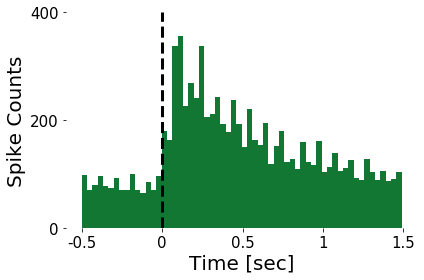

In [50]:
f, ax = plt.subplots()

ax = which_bin(df_aligned[df_aligned["neuron_id"] == stimulated_neuron], bins[:-1], 
          spiketimes_col="aligned")["bin_values"].hist(bins=60, ax=ax, 
                                                      color="#117733")

ax.grid(False)
ax.set(frame_on=False)

ax.set_yticks([0, 200, 400])
ax.set_yticklabels(ax.get_yticks(), fontsize=15)
ax.set_ylabel("Spike Counts", fontsize=20)

ax.set_xticks([-0.5, 0, 0.5, 1, 1.5])
ax.set_xticklabels([-0.5, 0, 0.5, 1, 1.5, 2], fontsize=15)

ax.set_xlabel("Time [sec]", fontsize=20)
ax = add_event_vlines(ax=ax, events=0, vline_kwargs={"linewidth": 3})

plt.tight_layout()
# plt.savefig(fig_dir / "FF_psth_stimulated_actual.svg", dpi=300, transparent=True)

In [51]:
inhibited_neurons = (
    df_effects
    .loc[lambda x: x["response_baseshock"] == "Inhibited"]
    .loc[lambda x: x.cluster == "fast_firing"]
    ["neuron_id"].values
)
inhibited_neuron = np.random.choice(stimulated_neurons, 1)[0]
print(inhibited_neuron)

1946


In [52]:
inhibited_neuron = 1878

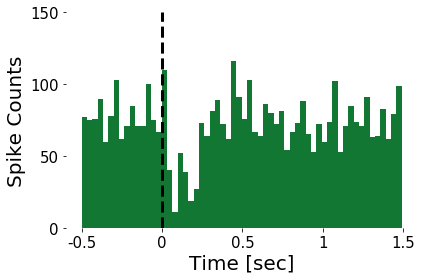

In [53]:
f, ax = plt.subplots()

ax = which_bin(df_aligned[df_aligned["neuron_id"] == inhibited_neuron], bins[:-1], 
          spiketimes_col="aligned")["bin_values"].hist(bins=60, ax=ax, 
                                                      color="#117733")

ax.grid(False)
ax.set(frame_on=False)

ax.set_yticks([0, 50, 100, 150])
ax.set_yticklabels(ax.get_yticks(), fontsize=15)
ax.set_ylabel("Spike Counts", fontsize=20)

ax.set_xticks([-0.5, 0, 0.5, 1, 1.5])
ax.set_xticklabels([-0.5, 0, 0.5, 1, 1.5, 2], fontsize=15)

ax.set_xlabel("Time [sec]", fontsize=20)
ax = add_event_vlines(ax=ax, events=0, vline_kwargs={"linewidth": 3})

plt.tight_layout()
# plt.savefig(fig_dir / "FF_psth_inhibited_actual.svg", dpi=300, transparent=True)

### NSA

In [54]:
stimulated_neurons = (
    df_effects
    .loc[lambda x: x["response_baseshock"] == "Stimulated"]
    .loc[lambda x: x.cluster == "no_baseline"]
    ["neuron_id"].values
)
stimulated_neuron = np.random.choice(stimulated_neurons, 1)[0]
print(stimulated_neuron)

1736


In [55]:
stimulated_neuron = 1708

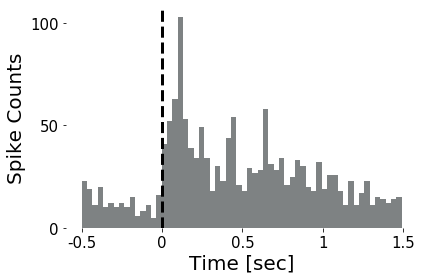

In [56]:
f, ax = plt.subplots()

ax = which_bin(df_aligned[df_aligned["neuron_id"] == stimulated_neuron], bins[:-1], 
          spiketimes_col="aligned")["bin_values"].hist(bins=60, ax=ax, 
                                                      color="#7E8283")

ax.grid(False)
ax.set(frame_on=False)

ax.set_yticks([0, 50, 100])
ax.set_yticklabels(ax.get_yticks(), fontsize=15)
ax.set_ylabel("Spike Counts", fontsize=20)

ax.set_xticks([-0.5, 0, 0.5, 1, 1.5])
ax.set_xticklabels([-0.5, 0, 0.5, 1, 1.5, 2], fontsize=15)

ax.set_xlabel("Time [sec]", fontsize=20)
ax = add_event_vlines(ax=ax, events=0, vline_kwargs={"linewidth": 3})

plt.tight_layout()
# plt.savefig(fig_dir / "NSA_psth_stimulated_actual.svg", dpi=300, transparent=True)

In [57]:
inhibited_neurons = (
    df_effects
    .loc[lambda x: x["response_baseshock"] == "Inhibited"]
    .loc[lambda x: x.cluster == "no_baseline"]
    ["neuron_id"].values
)
inhibited_neuron = np.random.choice(inhibited_neurons, 1)[0]
print(inhibited_neuron)

1700


In [58]:
inhibited_neuron = 1830

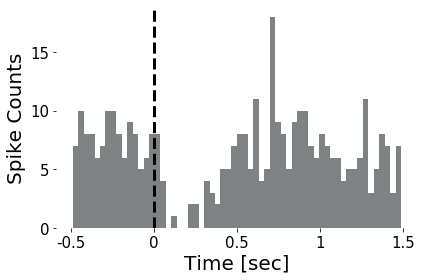

In [59]:
f, ax = plt.subplots()

ax = which_bin(df_aligned[df_aligned["neuron_id"] == inhibited_neuron], bins[:-1], 
          spiketimes_col="aligned")["bin_values"].hist(bins=60, ax=ax, 
                                                      color="#7E8283")

ax.grid(False)
ax.set(frame_on=False)

ax.set_yticks([0, 5, 10, 15])
ax.set_yticklabels(ax.get_yticks(), fontsize=15)
ax.set_ylabel("Spike Counts", fontsize=20)

ax.set_xticks([-0.5, 0, 0.5, 1, 1.5])
ax.set_xticklabels([-0.5, 0, 0.5, 1, 1.5, 2], fontsize=15)

ax.set_xlabel("Time [sec]", fontsize=20)
ax = add_event_vlines(ax=ax, events=0, vline_kwargs={"linewidth": 3})

plt.tight_layout()
# plt.savefig(fig_dir / "NSA_psth_inhibited_actual.svg", dpi=300, transparent=True)

## Subsection Analysis

In [60]:
df_effects.merge(dfb).dropna().session_name.nunique()

8

### First 5 Minutes

In [61]:
df_effects.response_baseshock.value_counts()

Stimulated       104
Non Responder     79
Inhibited         35
Name: response_baseshock, dtype: int64

In [62]:
df_spikes_sub = df_spikes2[df_spikes2["spiketimes"] < 2100]

In [63]:
psth_sub = (
    align_around_by(
        df_data=df_spikes_sub.merge(dfb[["neuron_id", "session_name"]]).dropna(),
        df_data_data_colname="spiketimes",
        df_data_group_colname="session_name",
        df_events=df_events,
        df_events_event_colname="event_s",
        df_events_group_colname="session_name",
        max_latency=1.5,
        t_before=0.5)
    .dropna()
    .pipe(lambda x: binned_spiketrain_bins_provided(x, 
                                bins=bins, 
                                spiketimes_col="aligned", 
                                spiketrain_col="neuron_id")
         )
)

In [64]:
psth_sub = (
    psth_sub
    .assign(cond=(
        lambda x: x["bin"].apply(lambda y: 0 if (y < 0.01) or (y > 0.3) else 1)
            ))
)

In [65]:
df_effects.response_baseshock.value_counts()

Stimulated       104
Non Responder     79
Inhibited         35
Name: response_baseshock, dtype: int64

In [66]:
df_effects_ff = (
    diffmeans_test_by(df=psth_sub, 
                        spiketrain_col="neuron_id", 
                        spikecount_col="counts", 
                        condition_col="cond")
    .rename(columns={"diff_of_means": "diff_of_means_first_5",
                    "p": "p_first_5"})
    .assign(p_first_5 = lambda x: p_adjust(x["p_first_5"]),
            response_first_5= lambda x: x.apply(response_dm, 
                                                  axis=1, 
                                                  p_colname="p_first_5",
                                                  diff_of_means_colname="diff_of_means_first_5")
           )
)
df_effects = pd.merge(df_effects, df_effects_ff)

In [67]:
df_effects.response_baseshock.value_counts()

Stimulated       104
Non Responder     79
Inhibited         35
Name: response_baseshock, dtype: int64

### Last 5 Minutes

In [68]:
df_spikes_sub = df_spikes2[df_spikes2["spiketimes"] > 2100]

In [69]:
psth_sub = (
    align_around_by(
        df_data=df_spikes_sub.merge(dfb[["neuron_id", "session_name"]]).dropna(),
        df_data_data_colname="spiketimes",
        df_data_group_colname="session_name",
        df_events=df_events,
        df_events_event_colname="event_s",
        df_events_group_colname="session_name",
        max_latency=1.5,
        t_before=0.5)
    .dropna()
    .pipe(lambda x: binned_spiketrain_bins_provided(x, 
                                bins=bins, 
                                spiketimes_col="aligned", 
                                spiketrain_col="neuron_id")
         )
)

In [70]:
psth_sub = (
    psth_sub
    .assign(cond=(
        lambda x: x["bin"].apply(lambda y: 0 if (y < 0.01) or (y > 0.3) else 1)
            ))
)

In [71]:
df_effects.response_baseshock.value_counts()

Stimulated       104
Non Responder     79
Inhibited         35
Name: response_baseshock, dtype: int64

In [79]:
df_effects_lf = (
    diffmeans_test_by(df=psth_sub, 
                        spiketrain_col="neuron_id", 
                        spikecount_col="counts", 
                        condition_col="cond")
    .rename(columns={"diff_of_means": "diff_of_means_last_5",
                    "p": "p_last_5"})
    .assign(p_first_5 = lambda x: p_adjust(x["p_last_5"]),
            response_last_5= lambda x: x.apply(response_dm, 
                                                  axis=1, 
                                                  p_colname="p_last_5",
                                                  diff_of_means_colname="diff_of_means_last_5")
           )
)
df_effects = pd.merge(df_effects, df_effects_lf, on="neuron_id")

In [80]:
df_effects_lf.response_last_5.value_counts()

Non Responder    109
Stimulated        81
Inhibited         28
Name: response_last_5, dtype: int64

### Second Shock Period

In [82]:
group_names_cs = ["acute_saline",  
            "acute_sal"]

block_name_cs = "chal_shock"

df_spikes_cs = (
    select_spike_times(
            engine, 
            metadata,
            group_names=group_names_cs,
            block_name=block_name_cs,
            )
    .assign(spiketimes=lambda x: x["spike_time_samples"].divide(fs))
)
df_events_cs = (
    select_discrete_data(
            engine,
            metadata,
            group_names=group_names_cs,
            block_name=block_name_cs
    )
    .assign(event_s= lambda x: x["timepoint_sample"].divide(fs))
)

In [83]:
df_spikes_cs.neuron_id.nunique()

77

In [84]:
df_spikes_cs = df_spikes_cs.groupby("neuron_id").filter(lambda x: len(x) >= 300)

In [85]:
psth_cs = (
    align_around_by(
        df_data=df_spikes_cs.merge(dfb[["neuron_id", "session_name"]]).dropna(),
        df_data_data_colname="spiketimes",
        df_data_group_colname="session_name",
        df_events=df_events_cs,
        df_events_event_colname="event_s",
        df_events_group_colname="session_name",
        max_latency=1.5,
        t_before=0.5)
    .dropna()
    .pipe(lambda x: binned_spiketrain_bins_provided(x, 
                                bins=bins, 
                                spiketimes_col="aligned", 
                                spiketrain_col="neuron_id")
         )
)

In [86]:
psth_cs = (
    psth_cs
    .assign(cond=(
        lambda x: x["bin"].apply(lambda y: 0 if (y < 0.01) or (y > 0.3) else 1)
            ))
)

In [87]:
df_effects_cs = (
    diffmeans_test_by(df=psth_cs, 
                        spiketrain_col="neuron_id", 
                        spikecount_col="counts", 
                        condition_col="cond")
    .rename(columns={"diff_of_means": "diff_of_means_chalshock",
                    "p": "p_chalshock"})
    .assign(p_chalshock = lambda x: p_adjust(x["p_chalshock"]),
            response_chalshock= lambda x: x.apply(response_dm, 
                                                  axis=1, 
                                                  p_colname="p_chalshock",
                                                  diff_of_means_colname="diff_of_means_chalshock"))
)
df_effects = pd.merge(df_effects_cs, df_effects, how="outer", on="neuron_id").merge(dfb[["neuron_id", "cluster", "group_name", "session_name"]])

In [90]:
df_effects.to_csv(data_dir / "psth_responses.csv", index=False)

In [91]:
df_effects.session_name.unique()

array(['hamilton_37', 'hamilton_32', 'hamilton_04', 'hamilton_09',
       'hamilton_31', 'hamilton_38', 'hamilton_35', 'hamilton_36'],
      dtype=object)

In [92]:
df_effects.shape

(218, 17)

In [89]:
df_effects.shape

(218, 17)